## Use OpenCV to get frames from url

In [1]:
import cv2

# HLS playlist URL
hls_url = "https://streamer4.brownrice.com/camdensnowbowl1/camdensnowbowl1.stream/main_playlist.m3u8"

cap = cv2.VideoCapture(hls_url)

frame_count = 0
frame_skip = 100  # Skip every 5 frames

if not cap.isOpened():
    print("Error: Could not open the HLS stream.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Frame not received, ending stream")
            break
        frame_count += 1
        if frame_count % frame_skip != 0:
            continue
        # Process your frame (e.g., people counting) here

        # For debugging, display the frame
        cv2.imshow("HLS Stream", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


## Count People in Web Cam Using YOLOv8

In [2]:
import cv2
from ultralytics import YOLO
import numpy as np
import torch
import os

# Import the necessary classes - this is a new issue with pytorch 2.6, could use 2.4 and not have to import all of these layers and add them to the globals list
from ultralytics.nn.tasks import DetectionModel  # Already imported for YOLOv8 models
from torch.nn.modules.container import Sequential    # For Sequential layers
from ultralytics.nn.modules.conv import Conv         # For Conv layers defined by Ultralytics
from torch.nn.modules.conv import Conv2d              # For PyTorch's Conv2d layer
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.activation import SiLU               # PyTorch's SiLU activation
from ultralytics.nn.modules.block import C2f                       # Ultralytics' C2f block
from torch.nn.modules.container import ModuleList
from ultralytics.nn.modules.block import Bottleneck
from ultralytics.nn.modules.block import SPPF
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.upsampling import Upsample
from ultralytics.nn.modules.conv import Concat
from ultralytics.nn.modules.head import Detect
from ultralytics.nn.modules.block import DFL
torch.serialization.add_safe_globals([
    DetectionModel, Sequential, Conv, Conv2d, BatchNorm2d, SiLU, C2f, ModuleList,
    Bottleneck, SPPF, MaxPool2d, Upsample, Concat, Detect, DFL
])

from src.config.config import frame_capture_settings


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the pretrained YOLOv8 model and move it to the appropriate device
model = YOLO(os.path.join(frame_capture_settings.model_path, frame_capture_settings.model_name)).to(device)
print(model.names)

# Define the HLS stream URL (the direct stream URL you extracted)
hls_url = "https://streamer4.brownrice.com/camdensnowbowl1/camdensnowbowl1.stream/main_playlist.m3u8"

# Open the video stream
cap = cv2.VideoCapture(hls_url)
if not cap.isOpened():
    print("Error: Could not open the video stream.")
    exit()

frame_skip = 20  # Process every 20th frame
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break
    frame_count += 1

    # Skip frames until we hit the desired interval
    if frame_count % frame_skip != 0:
        continue

    # Run YOLOv8 inference on the current frame.
    results = model(frame)
    
    # We'll use a copy of the frame to draw annotations.
    annotated_frame = frame.copy()
    people_count = 0

    # Process each detection result
    for result in results:
        if result.boxes is not None:
            boxes = result.boxes.data.cpu().numpy()  # shape: (num_boxes, 6)
            for box in boxes:
                x1, y1, x2, y2, conf, cls = box
                # In COCO, the 'person' class typically has an id of 0.
                if int(cls) >= 0:
                    bbox_color = (0, 255, 0)  # Green
                    if cls != 0:
                        bbox_color = (255, 0, 0)
                    cv2.rectangle(annotated_frame, (int(x1), int(y1)), (int(x2), int(y2)), bbox_color, 2)
                    people_count += 1
                    # Draw the bounding box and label on the frame.
                    cv2.putText(
                        annotated_frame,
                        f"{int(cls)} {conf:.2f}",
                        (int(x1), int(y1) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 255, 0),
                        2,
                    )
    
    # Overlay the people count on the frame.
    cv2.putText(
        annotated_frame,
        f"People Count: {people_count}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 255),
        2,
    )
    
    # Display the annotated frame
    cv2.imshow("YOLOv8 People Counting", annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the stream and close windows
cap.release()
cv2.destroyAllWindows()


Using device: cuda
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell 

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""



0: 384x640 (no detections), 22.4ms
Speed: 13.1ms preprocess, 22.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.7ms
Speed: 3.6ms preprocess, 10.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 19.9ms
Speed: 3.6ms preprocess, 19.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 19.5ms
Speed: 3.1ms preprocess, 19.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 19.6ms
Speed: 2.8ms preprocess, 19.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 72.0ms
Speed: 8.3ms preprocess, 72.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 19.2ms
Speed: 10.8ms preprocess, 19.2ms

## Create a dataset we can use to fine tune the model for counting people on this web cam
Saves every 1000th frame into the dataset/images/train folder and the associated YOLOv8 detected people annotations into the dataset/labels/train folder

Idea is we then go through these images after we gather a lot and improve upon the annotations. Then we fine tune the YOLO model with this data.

In [ ]:
import os
import cv2
import time
from ultralytics import YOLO
import torch

# Set up safe globals for PyTorch 2.6+ (include only if necessary)
from ultralytics.nn.tasks import DetectionModel
from torch.nn.modules.container import Sequential, ModuleList
from ultralytics.nn.modules.conv import Conv, Concat
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.activation import SiLU
from ultralytics.nn.modules.block import C2f, Bottleneck, SPPF, DFL
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.upsampling import Upsample
from ultralytics.nn.modules.head import Detect
torch.serialization.add_safe_globals([
    DetectionModel, Sequential, Conv, Conv2d, BatchNorm2d, SiLU, C2f, ModuleList,
    Bottleneck, SPPF, MaxPool2d, Upsample, Concat, Detect, DFL
])

# Adjustable parameters
WEBCAM_URL = "https://streamer4.brownrice.com/camdensnowbowl1/camdensnowbowl1.stream/main_playlist.m3u8"
FRAME_INTERVAL = 1000  # Process every 1000th frame
CONF_THRESHOLD = 0.4   # Confidence threshold
IMG_DIR = 'dataset/images/train'
LABEL_DIR = 'dataset/labels/train'


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load YOLOv8 model
model = YOLO("yolov8n.pt").to(device)

cap = cv2.VideoCapture(WEBCAM_URL)
if not cap.isOpened():
    print("Error: Could not open the video stream.")
    exit()

frame_count = 0

while True:
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    frame_count += 1
    # Process only every FRAME_INTERVAL frame
    if frame_count % FRAME_INTERVAL != 1:
        continue

    # Save the raw frame
    timestamp = int(time.time())
    img_filename = os.path.join(IMG_DIR, f"frame_{frame_count}_{timestamp}.jpg")
    cv2.imwrite(img_filename, frame)
    print(f"Saved image: {img_filename}")

    # Run YOLOv8 inference on the frame
    results = model(frame)
    height, width = frame.shape[:2]

    # Open a .txt file for writing the annotations in YOLO format
    txt_filename = os.path.splitext(img_filename)[0] + ".txt"
    txt_filename = txt_filename.replace("images", "labels")
    with open(txt_filename, "w") as f:
        for result in results:
            if result.boxes is not None:
                boxes = result.boxes.data.cpu().numpy()  # each row: [x1, y1, x2, y2, conf, cls]
                for box in boxes:
                    x1, y1, x2, y2, conf, cls = box
                    if conf >= CONF_THRESHOLD and int(cls) == 0:  # Only person (class 0)
                        # Convert bounding box to YOLO format (normalized)
                        x_center = ((x1 + x2) / 2.0) / width
                        y_center = ((y1 + y2) / 2.0) / height
                        bbox_width = (x2 - x1) / width
                        bbox_height = (y2 - y1) / height
                        # Write annotation line: class x_center y_center width height
                        f.write(f"0 {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")
    print(f"Saved annotations: {txt_filename}")

    # Optionally, display the frame (with no annotations drawn)
    #cv2.imshow("Dataset Collection", frame)


cap.release()
cv2.destroyAllWindows()

In [2]:
cap.release()
cv2.destroyAllWindows()

In [6]:
import os
from datetime import datetime, timezone, timedelta

# Hardcoded folder path (change this to your folder)
folder_path = 'dataset/labels/model_default'

# Define EST timezone (fixed offset of -5 hours from UTC)
est_tz = timezone(timedelta(hours=-5))

# Loop over all items in the folder
for filename in os.listdir(folder_path):
    # Process only files starting with "frame"
    if filename.startswith("frame"):
        full_path = os.path.join(folder_path, filename)
        if not os.path.isfile(full_path):
            continue  # Skip if not a file

        # Separate the file name from its extension
        base, ext = os.path.splitext(filename)
        parts = base.split("_")
        
        # We expect at least three parts (e.g., "frame", "146001", "1738885302")
        if len(parts) < 3:
            print(f"Skipping {filename}: does not have enough underscore-separated parts.")
            continue

        # The last part should be a Unix timestamp (as a string)
        timestamp_str = parts[-1]
        try:
            timestamp_val = int(timestamp_str)
        except ValueError:
            print(f"Skipping {filename}: timestamp '{timestamp_str}' is not an integer.")
            continue

        # Convert the Unix timestamp to a datetime in EST
        dt = datetime.fromtimestamp(timestamp_val, tz=est_tz)
        formatted_dt = dt.strftime("%Y_%m_%d_%H_%M_%S_%f")

        # Build the new file name
        new_filename = f"camdensnowbowl_{formatted_dt}{ext}"
        new_full_path = os.path.join(folder_path, new_filename)

        # Print the rename operation and perform the renaming
        print(f"Renaming '{filename}' to '{new_filename}'")
        os.rename(full_path, new_full_path)


Renaming 'frame_53001_1738879187.txt' to 'camdensnowbowl_2025_02_06_16_59_47_000000.txt'
Renaming 'frame_27001_1738877483.txt' to 'camdensnowbowl_2025_02_06_16_31_23_000000.txt'
Renaming 'frame_58001_1738879516.txt' to 'camdensnowbowl_2025_02_06_17_05_16_000000.txt'
Renaming 'frame_38001_1738878201.txt' to 'camdensnowbowl_2025_02_06_16_43_21_000000.txt'
Renaming 'frame_66001_1738880045.txt' to 'camdensnowbowl_2025_02_06_17_14_05_000000.txt'
Renaming 'frame_3000_1738873355.txt' to 'camdensnowbowl_2025_02_06_15_22_35_000000.txt'
Renaming 'frame_56001_1738879386.txt' to 'camdensnowbowl_2025_02_06_17_03_06_000000.txt'
Renaming 'frame_52001_1738879122.txt' to 'camdensnowbowl_2025_02_06_16_58_42_000000.txt'
Renaming 'frame_184001_1738887801.txt' to 'camdensnowbowl_2025_02_06_19_23_21_000000.txt'
Renaming 'frame_182001_1738887671.txt' to 'camdensnowbowl_2025_02_06_19_21_11_000000.txt'
Renaming 'frame_81001_1738881028.txt' to 'camdensnowbowl_2025_02_06_17_30_28_000000.txt'
Renaming 'frame_7900

In [ ]:
# src/finetune_model_training.py

import os
from ultralytics import YOLO
from config.config import frame_capture_settings  # Adjust if necessary


def fine_tune_external():
    """
    Stage 1: Fine tune on a large, external people detection dataset.
    The external dataset should be specified in dataset/data_external.yaml.
    """
    print("Starting fine tuning on external dataset...")

    # Path to your pre-trained model (e.g., YOLOv8n)
    model_path = os.path.join(frame_capture_settings.model_path, frame_capture_settings.model_name)
    model = YOLO(model_path)

    # YAML configuration for external dataset (ensure this file exists and is configured properly)
    external_data_yaml = "dataset/data_external.yaml"

    # Fine tune on the external dataset
    results = model.train(
        data=external_data_yaml,       # external dataset configuration
        epochs=50,                     # adjust epochs as needed
        imgsz=640,                     # target image size
        batch=16,                      # batch size (adjust based on your hardware)
        project="finetune",            # project name for saving results
        name="yolov8n_external_finetune"  # run name for external fine tuning
    )

    print("External fine tuning complete!")
    # Optionally, you can save the model checkpoint explicitly.
    # For example:
    # model.save("src/models/yolov8n_external_finetune.pt")
    # Here, we assume that the best checkpoint is saved by default (e.g., in runs/train/yolov8n_external_finetune/weights/)
    return model  # returning the fine tuned model


def fine_tune_target(model_checkpoint=None):
    """
    Stage 2: Fine tune on the target domain (ski resort webcam images).
    The target domain dataset should be specified in dataset/data_target.yaml.
    If a checkpoint is provided, load that; otherwise, use the default best checkpoint from stage 1.
    """
    print("Starting fine tuning on target domain...")

    # Load the model from a checkpoint if provided; otherwise, assume the external fine tuning best checkpoint is in a known location.
    if model_checkpoint:
        model = YOLO(model_checkpoint)
    else:
        # Adjust this path if necessary based on where the external fine tuning checkpoint is saved.
        checkpoint_path = "runs/train/yolov8n_external_finetune/weights/best.pt"
        model = YOLO(checkpoint_path)

    # YAML configuration for target domain dataset (ski resort images)
    target_data_yaml = "dataset/data_target.yaml"

    # Fine tune on the target domain dataset
    results = model.train(
        data=target_data_yaml,         # target domain dataset configuration
        epochs=20,                    # typically fewer epochs to adapt to the target domain
        imgsz=640,                    # target image size (should match your deployment/inference resolution)
        batch=16,                     # batch size
        project="finetune",           # project name for saving results
        name="yolov8n_target_finetune"  # run name for target domain fine tuning
    )

    print("Target domain fine tuning complete!")
    # Optionally, save the final model checkpoint:
    # model.save("src/models/yolov8n_target_finetune.pt")
    return model


def main():
    # Stage 1: Fine tune on external dataset.
    external_model = fine_tune_external()

    # Stage 2: Fine tune on target domain (using the best checkpoint from Stage 1).
    # You can pass an explicit checkpoint path if you saved it separately.
    target_model = fine_tune_target()

    print("Sequential fine tuning completed successfully.")


if __name__ == "__main__":
    main()


In [14]:
import torch
from ultralytics import YOLO
from ultralytics.nn.tasks import DetectionModel
from torch.nn.modules.container import Sequential, ModuleList
from ultralytics.nn.modules.conv import Conv, Concat
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.activation import SiLU
from ultralytics.nn.modules.block import C2f, Bottleneck, SPPF, DFL
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.upsampling import Upsample
from ultralytics.nn.modules.head import Detect
from ultralytics.utils.loss import v8DetectionLoss, BboxLoss  # Import BboxLoss along with any other loss classes
from ultralytics.utils import IterableSimpleNamespace
from torch.nn.modules.loss import BCEWithLogitsLoss
from ultralytics.utils.tal import TaskAlignedAssigner

# Add all required globals to the safe list
torch.serialization.add_safe_globals([
    DetectionModel, Sequential, Conv, Conv2d, BatchNorm2d, SiLU, C2f, ModuleList,
    Bottleneck, SPPF, MaxPool2d, Upsample, Concat, Detect, DFL,
    IterableSimpleNamespace, v8DetectionLoss, BCEWithLogitsLoss, TaskAlignedAssigner, BboxLoss
])
# Load the best model weights from your training run
best_model = YOLO("finetune/yolov8n_external_finetune3/weights/best.pt")

# You can now use best_model for inference, evaluation, etc.
results = best_model("datasets/dataset_webcam/images/train")

c=0
for r in results:
    c+=1
    if c>5:
        break
    r.show()  # Display detections




image 1/392 /home/ddd/people-counter/datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_15_20_23_000000.jpg: 384x640 12 persons, 18.4ms
image 2/392 /home/ddd/people-counter/datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_15_21_28_000000.jpg: 384x640 5 persons, 14.7ms
image 3/392 /home/ddd/people-counter/datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_15_22_35_000000.jpg: 384x640 2 persons, 17.1ms
image 4/392 /home/ddd/people-counter/datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_15_37_15_000000.jpg: 384x640 11 persons, 17.4ms
image 5/392 /home/ddd/people-counter/datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_15_37_58_000000.jpg: 384x640 5 persons, 15.0ms
image 6/392 /home/ddd/people-counter/datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_16_01_56_000000.jpg: 384x640 11 persons, 9.4ms
image 7/392 /home/ddd/people-counter/datasets/dataset_webcam/images/train/camdensnowbowl_2025_02_06_16_02_48_000000

: 

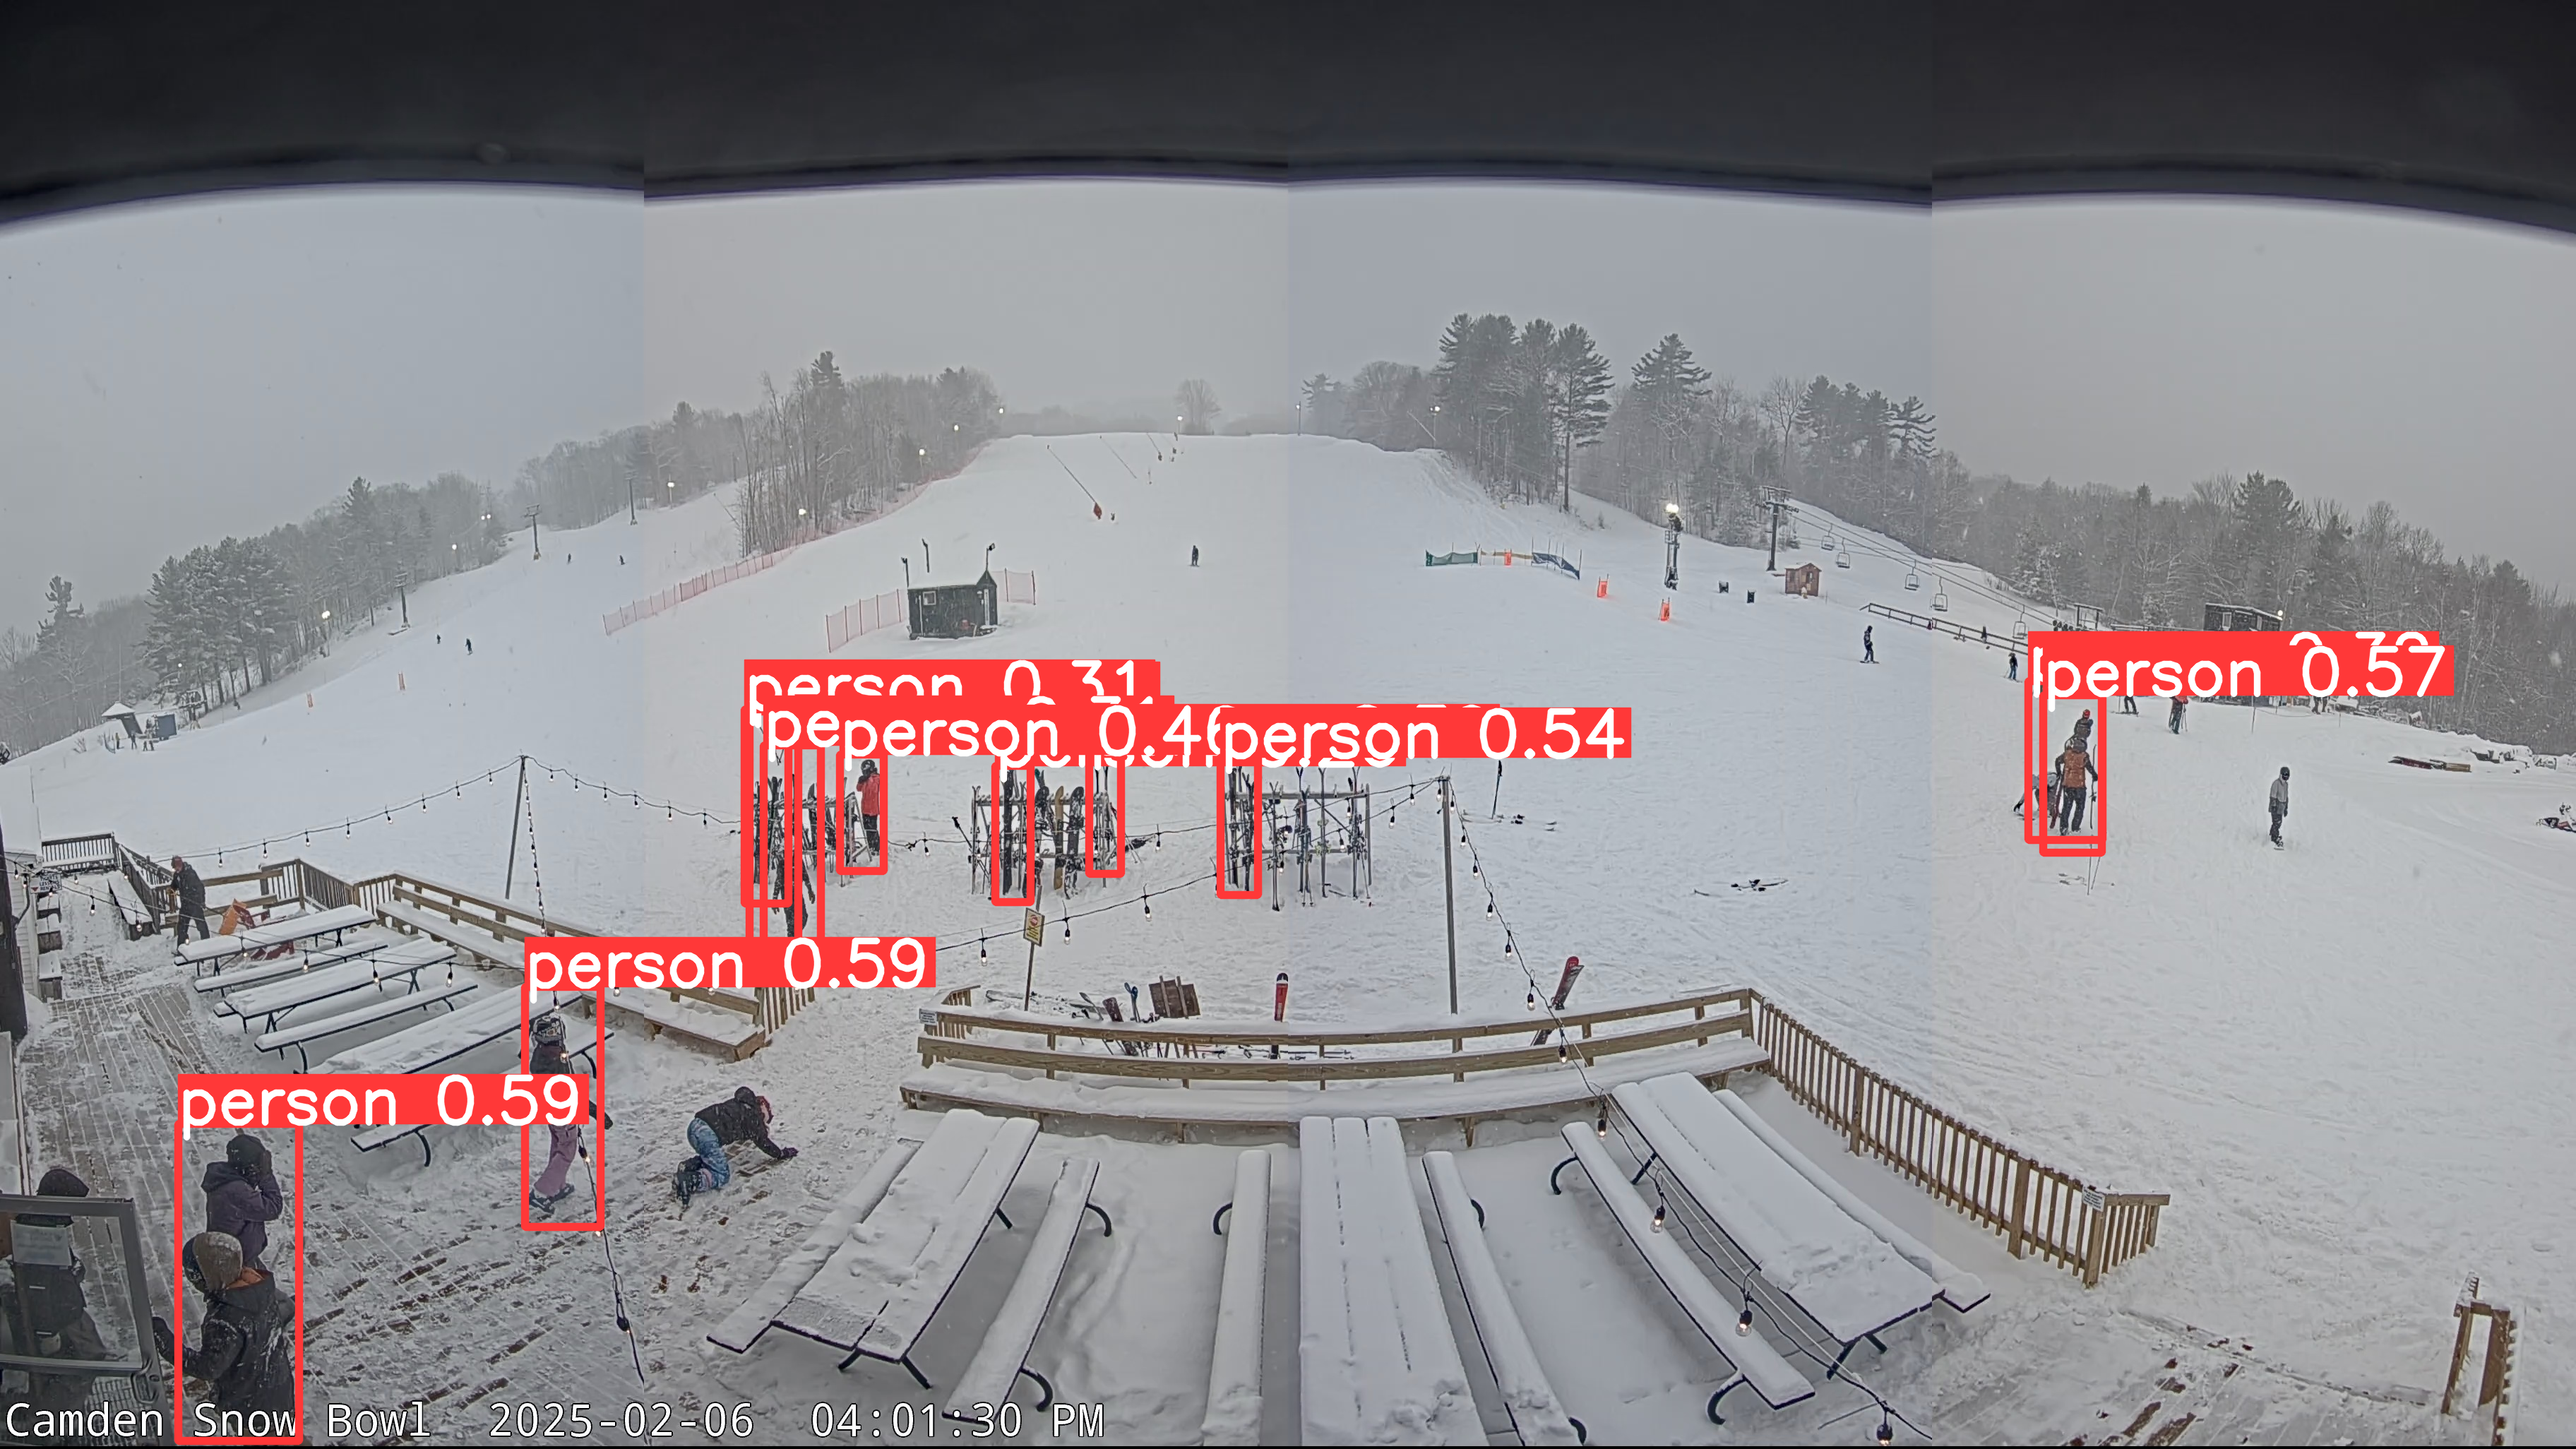

In [13]:
results[0].show()